# Z:P ratio compared with trophic position! 

In [3]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import xarray as xr
import cartopy.crs as ccrs

import geoviews as gv
import holoviews as hv
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import seaborn as sns
import scipy.io as sio

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean
from cartopy.util import add_cyclic_point

In [4]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [5]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result


In [6]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [8]:
print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

What is the new file? (new_file)


 GNG595


What year? (year)


 20yrclim


In [9]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [10]:
## Jessica's Path 
jluo_path = '/glade/scratch/jluo/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
path_file = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## Gaby's Path 
gabyn_path = '/glade/scratch/gabyn/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## 10 year climatology from year 53 - 62 representing Jan 2000-Dec 2009
new_path = '/glade/scratch/jluo/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

In [11]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_1990-2009_clim/GNG595_clim_1990-2009_*', recursive=True),
                      key=numericalSort)

ds= xr.open_mfdataset(newNCDFfiles,combine='by_coords')

In [12]:
mmolcm3pm3s_to_gpy = 1e-6 * 1.2011e-2 * 86400 * 365
mmolcm2pm2s_to_gpy = 1e-4 * 1.2011e-2 * 86400 * 365
mmolcm2pm2_to_g = 1e-4 * 1.2011e-2

In [13]:
zoo_var_names = ['zoo1', 'zoo2','zoo3', 'zoo4', 'zoo5', 'zoo6']
total_zoo_prod = xr.concat([ds['x_graze_' + v + '_zint'] for v in zoo_var_names], dim='var').sum(dim='var') * ds.TAREA * mmolcm3pm3s_to_gpy # mmol/m^3 cm/s to g C yr-1

zooC = xr.concat([ds[v+'C'] for v in zoo_var_names], dim='var').sum(dim='var')
zooC_zint = zooC.sum(dim='z_t_150m') * 10

In [14]:
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'C' for v in phyto_names] # mmol C /m^3
phytoC = xr.concat([ds[v] for v in phyto_vars], dim='var').sum(dim='var') # units are mmol
phytoC_zint = phytoC.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2

Text(0, 0.5, '$log_{10}$(Z:P biomass ratio) ')

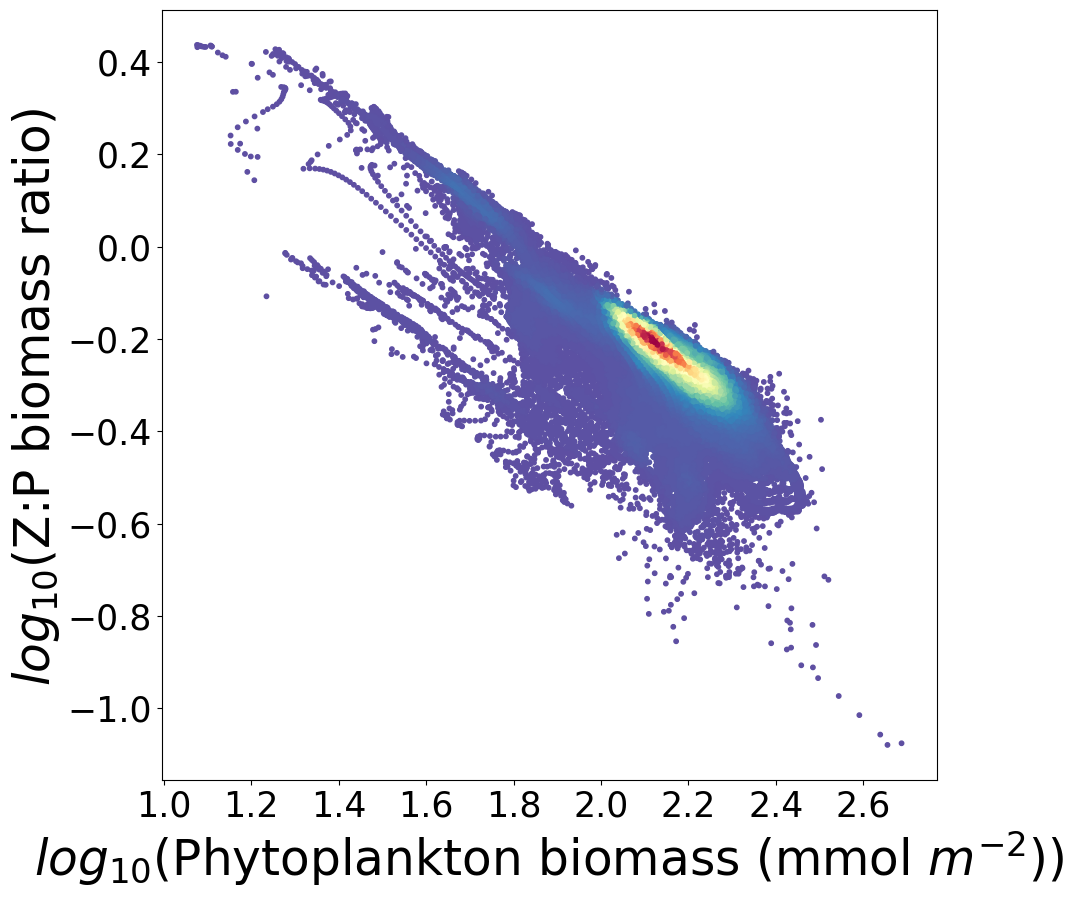

In [15]:
%% time
from scipy import stats
from scipy.stats import gaussian_kde
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)
XX = np.nanmean(phytoC_zint,axis=0)
YY = np.nanmean(zooC_zint,axis=0)/np.nanmean(phytoC_zint,axis=0)

X=np.array(XX)[~np.isnan(XX)& ~np.isnan(YY)]
Y=np.array(YY)[~np.isnan(XX)& ~np.isnan(YY)]

xy = np.vstack([np.log10(X),np.log10(Y)])
z = gaussian_kde(xy)(xy)
plt.scatter(y=np.log10(Y),x=np.log10(X), c=z,s=10, alpha=1,cmap='Spectral_r')
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('$log_{10}$(Phytoplankton biomass (mmol $m^{-2}$))', fontsize=35)
plt.ylabel('$log_{10}$(Z:P biomass ratio) ',fontsize = 35)

### Calculating Zooplankton Mean Torphic Level

In [17]:
## Gaby's Path 
jluo_path = '/glade/u/home/jluo/cesm_scripts/size_structured/nl_input/cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
gabyn_path = '/glade/u/home/gabyn/work/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
nl_config = os.path.join(''+gabyn_path+new_file+'/data/')
sizes = pd.read_csv(nl_config+'plankton_sizes.csv')
sizes = sizes.sort_values('mmolC')
sizes

,type,sname,mass_ugC,vol_um3,ESD_mm,Qp_fixed,mmolC
1,phyto,pp,9.266989e-08,3.706795e-01,0.000891,0.004651,7.715418e-12
2,phyto,mp1,8.241979e-06,1.805089e+01,0.003255,0.006824,6.862025e-10
0,phyto,diaz,5.499929e-05,1.227865e+02,0.006167,0.003333,4.579077e-09
3,phyto,mp2,8.888712e-05,8.790197e+02,0.011885,0.008656,7.400476e-09
6,phyto,diat1,5.004513e-04,1.327390e+04,0.029376,0.010289,4.166608e-08
9,zoo,zoo1,2.803686e-03,2.355042e+04,0.035563,0.008547,2.334265e-07
7,phyto,diat2,3.803133e-03,1.326626e+05,0.063278,0.012602,3.166375e-07
4,phyto,mp3,4.830334e-03,4.280541e+04,0.043401,0.012907,4.021592e-07
8,phyto,diat3,2.890156e-02,1.325863e+06,0.136301,0.015435,2.406258e-06
10,zoo,zoo2,8.933984e-02,7.447577e+05,0.112462,0.008547,7.438168e-06


In [18]:
grazing=pd.read_csv(nl_config+'grazing_input_data.csv')
grazing = grazing.dropna(subset=['sname1','sname2'])
grazing = grazing[['sname1', 'sname2', 'z_umax_0_per_day']]


# calculate sum of the z_umax values
# by prey
sum_z_umax_by_prey = pd.DataFrame(grazing.groupby(['sname1'])['z_umax_0_per_day'].sum())
sum_z_umax_by_prey = sum_z_umax_by_prey.rename(index=str, columns={'z_umax_0_per_day':'sum_z_umax_by_prey'})

# by pred
sum_z_umax_by_pred = pd.DataFrame(grazing.groupby(['sname2'])['z_umax_0_per_day'].sum())
sum_z_umax_by_pred = sum_z_umax_by_pred.rename(index=str, columns={'z_umax_0_per_day':'sum_z_umax_by_pred'})

# join and calculate a per-grazer percentage
grazing = grazing.set_index('sname1').join(sum_z_umax_by_prey)
grazing['z_umax_pct_by_prey'] = grazing.z_umax_0_per_day / grazing.sum_z_umax_by_prey
grazing = grazing.reset_index()

grazing = grazing.set_index('sname2').join(sum_z_umax_by_pred)
grazing['z_umax_pct_by_pred'] = grazing.z_umax_0_per_day / grazing.sum_z_umax_by_pred
grazing = grazing.reset_index()
grazing.head(5)

,sname2,sname1,z_umax_0_per_day,sum_z_umax_by_prey,z_umax_pct_by_prey,sum_z_umax_by_pred,z_umax_pct_by_pred
0,zoo1,diat1,0.147034,1.953287,0.075275,10.362452,0.014189
1,zoo1,diaz,3.424788,3.603350,0.950446,10.362452,0.330500
2,zoo1,mp1,3.059491,3.059491,1.000000,10.362452,0.295248
3,zoo1,mp2,1.836484,7.934161,0.231465,10.362452,0.177225
4,zoo1,pp,1.894655,1.894655,1.000000,10.362452,0.182839


In [19]:
# clear zeros in the zooplankton carbon biomass
zoo1C = ds.zoo1C.values
zoo2C = ds.zoo2C.values
zoo3C = ds.zoo3C.values
zoo4C = ds.zoo4C.values
zoo5C = ds.zoo5C.values
zoo6C = ds.zoo6C.values

zoo1C[np.where(zoo1C < 0)] = 0
zoo2C[np.where(zoo2C < 0)] = 0
zoo3C[np.where(zoo3C < 0)] = 0
zoo4C[np.where(zoo4C < 0)] = 0
zoo5C[np.where(zoo5C < 0)] = 0
zoo6C[np.where(zoo6C < 0)] = 0

ds.zoo1C.values = zoo1C
ds.zoo2C.values = zoo2C
ds.zoo3C.values = zoo3C
ds.zoo4C.values = zoo4C
ds.zoo5C.values = zoo5C
ds.zoo6C.values = zoo6C

In [20]:
for sname in sizes.sname:
    var = sname+'C'
    newv = sname+'_n'
    sname_n = ds[var]/sizes[sizes.sname==sname].mmolC.values
    ds[newv] = sname_n
    ds[newv].attrs = {'units':'count/m^3'}

In [21]:
ZN=np.zeros(ds.zoo1_n.shape)
ZNSIZE=np.zeros(ds.zoo1_n.shape)

for zname in sizes[sizes.type=='zoo'].sname:
    zn = zname+'_n'
    ZN=ZN+ds[zn].values
    ZNSIZE = ZNSIZE + (ds[zn].values * sizes[sizes.sname==zname].ESD_mm.values)

zoo_size=ZNSIZE/ZN * 1000 
ds['zoo_size'] = (('time','z_t_150m','nlat','nlon'), zoo_size)
ds['zoo_size'].attrs = {'long_name':'Zooplankton mean size (as equivalent spherical diameter)',
                       'units':'micrometers'}

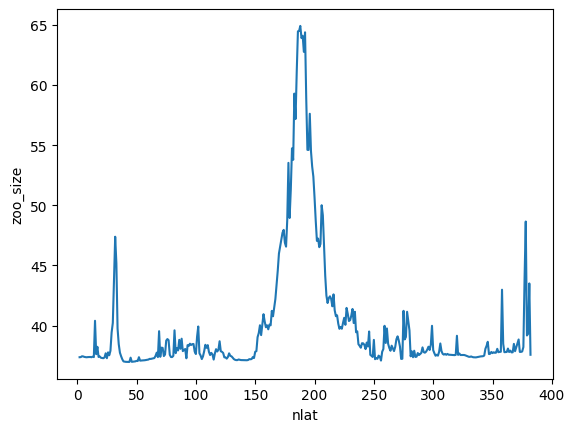

In [22]:
ds.zoo_size.mean(dim=['time','z_t_150m', 'nlon']).plot()

In [23]:
total_prim_prod = ds.photoC_TOT.sum(dim='z_t_150m') * 10 * ds.TAREA * mmolcm2pm2s_to_gpy

print(total_prim_prod.sum(dim=['nlat', 'nlon']).mean(dim='time').values)

5.14531557337071e+16


In [24]:
POC_flux = ds.POC_FLUX_IN.isel(z_t=10) * ds.TAREA * mmolcm3pm3s_to_gpy
POC_flux.sum(dim=['nlat', 'nlon']).mean(dim='time').values

e_ratio = POC_flux / total_prim_prod
print(e_ratio)

<xarray.DataArray (time: 12, nlat: 384, nlon: 320)>
dask.array<truediv, shape=(12, 384, 320), dtype=float64, chunksize=(1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0104-02-01 00:00:00 ... 0105-01-01 00:00:00
    z_t      float32 1.05e+04
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon


In [25]:
microzoo = ['zoo1', 'zoo2']
mesozoo = ['zoo3', 'zoo4', 'zoo5', 'zoo6']

ds['microzooProd_zint'] = xr.concat([ds['x_graze_' + v + '_zint'] for v in microzoo], dim='var').sum(dim='var')
ds['mesozooProd_zint'] = xr.concat([ds['x_graze_' + v + '_zint'] for v in mesozoo], dim='var').sum(dim='var')

microzooProd = ds['microzooProd_zint'] * ds.TAREA * mmolcm3pm3s_to_gpy
print('Microzooplankton Production: ' + '{:.2e}'.format(microzooProd.mean(dim='time').sum().values) + ' Pg C yr-1')

mesozooProd = ds['mesozooProd_zint'] * ds.TAREA * mmolcm3pm3s_to_gpy
print('Mesozooplankton Production: ' + '{:.2e}'.format(mesozooProd.mean(dim='time').sum().values) + ' Pg C yr-1')

Microzooplankton Production: 8.77e+15 Pg C yr-1
Mesozooplankton Production: 3.32e+15 Pg C yr-1


In [26]:
microzoo = ['zoo1', 'zoo2']
mesozoo = ['zoo3', 'zoo4', 'zoo5', 'zoo6']

ds['microzooC_zint'] = xr.concat([ds[v+'C'] for v in microzoo], dim='var').sum(dim='var')
ds['microzooC_zint'] = ds['microzooC_zint'].sum(dim='z_t_150m') * 10
ds['mesozooC_zint'] = xr.concat([ds[v+'C'] for v in mesozoo], dim='var').sum(dim='var')
ds['mesozooC_zint'] = ds['mesozooC_zint'].sum(dim='z_t_150m') * 10

microzooC = ds['microzooC_zint'] * ds.TAREA * mmolcm2pm2_to_g
print('Microzooplankton Carbon: ' + '{:.2e}'.format(microzooC.sum().values) + ' Pg C')

mesozooC = ds['mesozooC_zint'] * ds.TAREA * mmolcm2pm2_to_g
print('Mesozooplankton Carbon: ' + '{:.2e}'.format(mesozooC.sum().values) + ' Pg C')

Microzooplankton Carbon: 1.74e+15 Pg C
Mesozooplankton Carbon: 2.38e+15 Pg C


In [27]:
prey_varnames = {}
for i,v in enumerate(sizes.sname):
    prey_varnames[v]=i

In [28]:
pred_varnames = {'zoo1':0,'zoo2':1,'zoo3':2,'zoo4':3,'zoo5':4,'zoo6':5}
grazing_vars = [v for v in ds if 'graze' in v and 'zint' not in v]

In [29]:
graze_split = [v.split('_',3) for v in grazing_vars]
graze_split = pd.DataFrame(graze_split)
graze_split = graze_split.rename({0:'var',1:'prey',2:'pred'}, axis=1)
graze_split['var'] = grazing_vars

In [30]:
grazing_vars
graze_split.head(5)

,var,prey,pred
0,graze_diaz_zoo1,diaz,zoo1
1,graze_diaz_zoo2,diaz,zoo2
2,graze_diaz_zoo3,diaz,zoo3
3,graze_pp_zoo1,pp,zoo1
4,graze_mp1_zoo1,mp1,zoo1


In [31]:
graze_split['prey_ind']=np.nan # add column for the prey idex 
graze_split['pred_ind']=np.nan # add column for the predator idex 
graze_split['val']=np.nan # add column for the grazing value of the predator prey 

In [32]:
graze_split_a = np.array(graze_split) # Create this dataframe into an array to be more easily manipulated. 

In [33]:
for i in range(len(graze_split.index)):
    graze_split_a[i,3] = prey_varnames[graze_split_a[i,1]] # populate index of prey in array 
    graze_split_a[i,4] = pred_varnames[graze_split_a[i,2]] # populate idex of predator in array 
    graze_split_a[i,5] = ds[graze_split_a[i,0]].sum(dim='z_t_150m').mean().values # add grazing value for corresponding grazing pair(mmol/m^3/s)

In [34]:
df_graze = pd.DataFrame(np.array(graze_split_a),
                  columns=['var', 'prey','pred','prey_ind','pred_ind','val']) # rename grazing array and convert into dataframe.

In [35]:
df_graze = df_graze.sort_values(by=['prey_ind','pred_ind']) # sort dataframe by the index prey and predator values. 

In [36]:
df=df_graze.pivot(index='prey_ind',columns='pred',values='val') # print grazing array. 
df.index=sizes.sname[0:14]
df.index.rename('prey')
df

pred,zoo1,zoo2,zoo3,zoo4,zoo5,zoo6
sname,,,,,,
pp,3.385291e-06,NaN,NaN,NaN,NaN,NaN
mp1,5.553468e-07,4.580991e-15,NaN,NaN,NaN,NaN
diaz,1.0526728e-07,1.9920834e-09,0.0,NaN,NaN,NaN
mp2,NaN,2.1760204e-08,1.1585631e-11,0.0,NaN,NaN
diat1,1.0317407e-07,8.015418e-08,9.790502e-07,2.544117e-11,NaN,NaN
zoo1,NaN,5.8513372e-08,3.4098537e-07,NaN,NaN,NaN
diat2,NaN,4.632332e-09,4.9707463e-08,2.5077687e-08,0.0,NaN
mp3,NaN,NaN,9.260858e-09,3.050629e-10,0.0,NaN
diat3,NaN,NaN,6.892266e-09,1.1089646e-08,5.8053677e-09,0.0


In [37]:
zoo_names = { 'zoo_names': ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']}
zn = pd.DataFrame(data=zoo_names)

phyto_names = { 'phyto_names': ['pp','mp1','diaz','mp2','diat1','diat2','mp3','diat3','mp4']}
pn = pd.DataFrame(data=phyto_names)

In [38]:
tl = df.copy() # Create copy of grazing dataframe 
tlvals = np.empty(shape=6) # create empty array for trophic level values
tlvals[:] = np.nan # populate this array with NANS

for i,v in enumerate(zn.zoo_names): # iterates through every zooplanknton (prey)
    # creates a sum of all grazing values for each prey multiplied by initial TL value (1 for phyto, nan for zooplankton) 
    # divided by the sum of all grazing values for each prey. ADDS 1 becuase they are all above tophic level 1. 
    tlvals[i] = 1 + np.sum(tl[v] * np.append(np.ones(shape=9),tlvals[0:5])) / np.sum(tl[v])  
    # fill the dataframe with the trophic level values for each zooplankton value. 
    tl[v] = tl[v] * np.append(np.ones(shape=9),tlvals[0:5]) / tl[v]

print(tlvals)

[2.00000002 2.         2.00351427 2.39813933 2.95596237 3.68520135]


In [39]:
zooTL = (ds.zoo1C * tlvals[0] + ds.zoo2C * tlvals[1] + ds.zoo3C * tlvals[2] + ds.zoo4C * tlvals[3] + ds.zoo5C * tlvals[4] + ds.zoo6C * tlvals[5]) / (ds.zoo1C + ds.zoo2C + ds.zoo3C + ds.zoo4C + ds.zoo5C + ds.zoo6C)
zooTL.mean().values

array(2.379922, dtype=float32)

In [42]:
lev = (2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.1,3.2,3.3,3.4,3.5)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.75)

plt.rc('font', size=16)
plt.rc('axes', titlesize=12)
plt.rc('figure', titlesize=18)

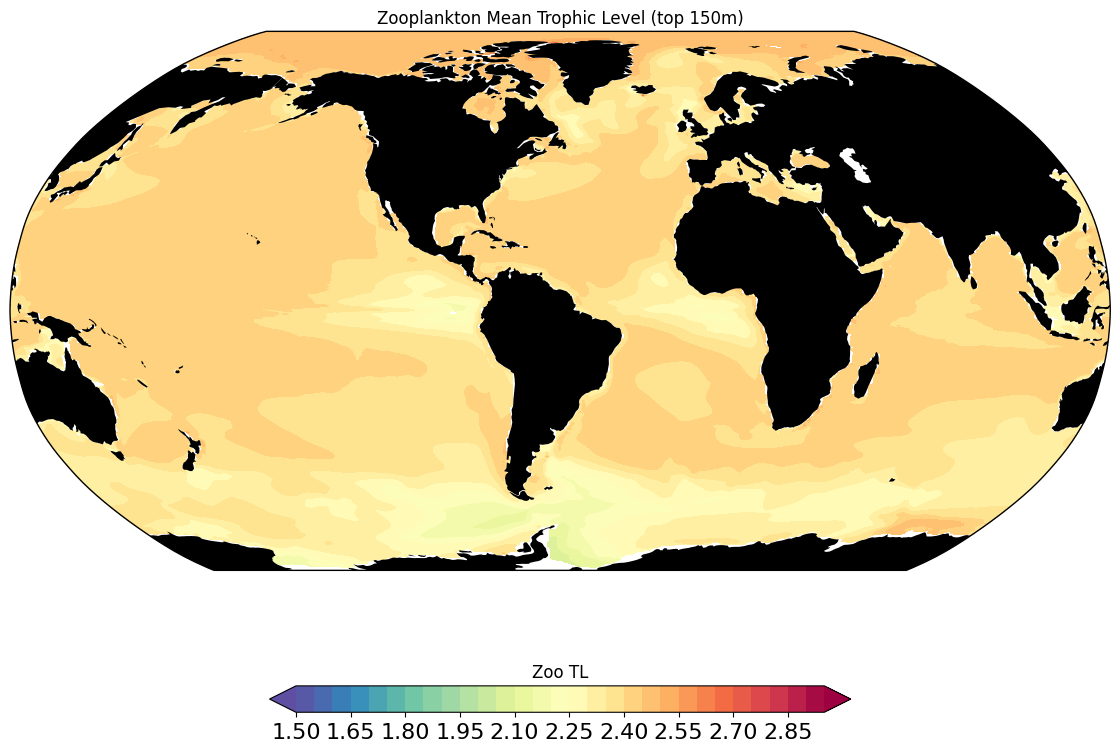

In [56]:
lev = np.arange(1.5, 3, 0.05)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.25)

fig = plt.figure(figsize=(15, 10))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, zooTL.mean(dim=['z_t_150m','time']).values)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r', levels=lev, norm = norm,extend='both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('Zoo TL')
ax.set_title('Zooplankton Mean Trophic Level (top 150m)');

## Calculate the zooplankton mean trophic level at each grid cell 

In [44]:
zoods = xr.DataArray(zoo1C, coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods = zoods.to_dataset(name='zoo1C')

zoods['zoo2C'] = xr.DataArray(zoo2C, coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo3C'] = xr.DataArray(zoo3C, coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo4C'] = xr.DataArray(zoo4C, coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo5C'] = xr.DataArray(zoo5C, coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo6C'] = xr.DataArray(zoo6C, coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])

## Grazing flux based on trophic level 

In [45]:
zoo = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']

In [46]:
# set trophic level for phyto = 1
tmpOnes = np.ones(shape=ds.diazC.shape)
tlvals = {}
for v in pn.phyto_names:
    tlvals[v]=tmpOnes

# set trophic level for zoo = NaN initially
tmp = tmpOnes.copy()
tmp[:] = np.nan
for v in zn.zoo_names:
    tlvals[v]=tmp


for i,vs in enumerate(zn.zoo_names):
    
    # pull out the appropriate grazing variables in the history file
    graze_vars = [v for v in ds if re.match('graze_(.*)_'+vs,v)]
    
    # holder for the grazing values
    shape = ds[graze_vars[0]].shape + (len(graze_vars),)

    graze_vals = np.empty(shape=shape)
    graze_tl = np.ones(shape=shape)
    
    for gi,gv in enumerate(graze_vars):
        
        # pull out identity of prey
        g,prey,pred = gv.split('_',3)
        print(prey,pred)
        
        # if prey is zooplankton, then apply alternate trophic level
        if prey in zoo:
            graze_tl[...,gi]=tlvals[prey]
        
        graze_vals[...,gi] = ds[gv].values # Ellipses select the last slice
    # graze_vals*grazetl/graze_vals    
    tlvals[vs] = 1 + (np.sum(graze_vals * graze_tl, axis=-1) / np.sum(graze_vals, axis=-1)) # axis=-1 means sum over the last axis

diaz zoo1
pp zoo1
mp1 zoo1
diat1 zoo1
diaz zoo2
mp1 zoo2
mp2 zoo2
diat1 zoo2
diat2 zoo2
zoo1 zoo2
diaz zoo3
mp2 zoo3
mp3 zoo3
diat1 zoo3
diat2 zoo3
diat3 zoo3
zoo1 zoo3
zoo2 zoo3
mp2 zoo4
mp3 zoo4
mp4 zoo4
diat1 zoo4
diat2 zoo4
diat3 zoo4
zoo2 zoo4
zoo3 zoo4
mp3 zoo5
mp4 zoo5
diat2 zoo5
diat3 zoo5
zoo3 zoo5
zoo4 zoo5
mp4 zoo6
diat3 zoo6
zoo4 zoo6
zoo5 zoo6


In [47]:
np.nanmax(tlvals['zoo6'])

5.821950969749857

In [48]:
zoods['zoo1TL'] = xr.DataArray(tlvals['zoo1'], coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo2TL'] = xr.DataArray(tlvals['zoo2'], coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo3TL'] = xr.DataArray(tlvals['zoo3'], coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo4TL'] = xr.DataArray(tlvals['zoo4'], coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo5TL'] = xr.DataArray(tlvals['zoo5'], coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo6TL'] = xr.DataArray(tlvals['zoo6'], coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])

In [49]:
zoods['zooTL_g'] = xr.concat([zoods[v+'TL'] for v in ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']],dim='var')

In [50]:
np.save("zoo_TL.npy", zoods.zooTL_g)

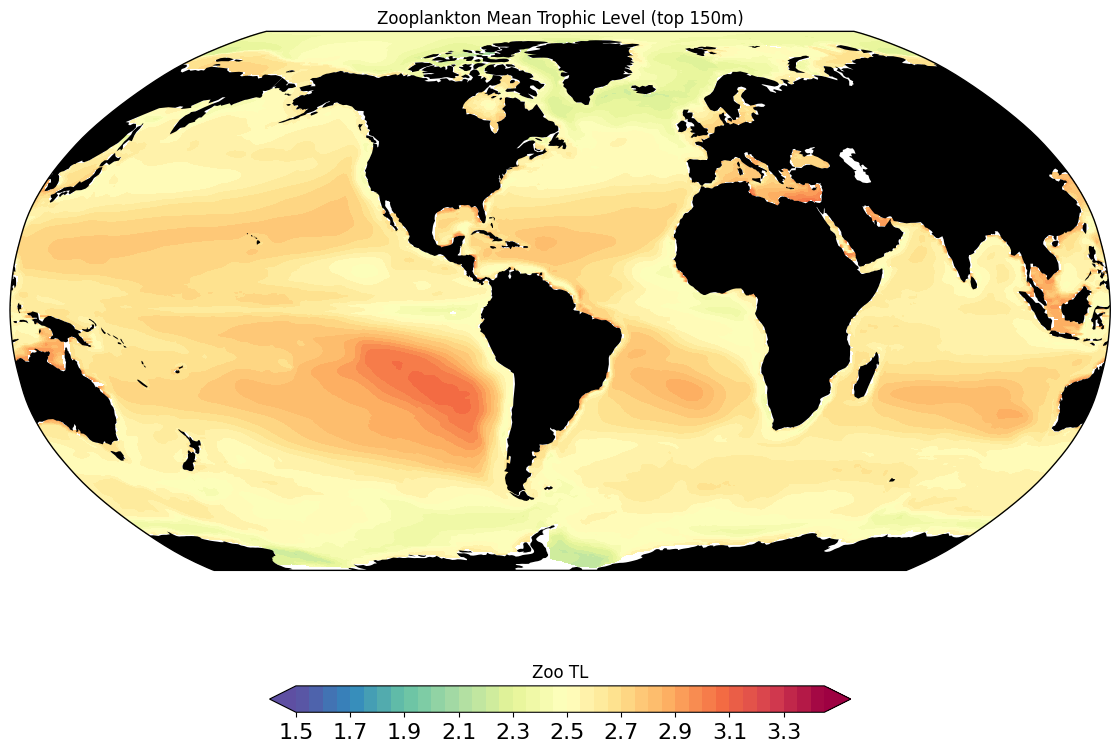

In [58]:
lev = np.arange(1.5, 3.5, 0.05)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)

fig = plt.figure(figsize=(15, 10))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, zoods.zooTL_g.mean(dim=['z_t_150m','time','var']).values)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r', levels=lev, norm = norm,extend='both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('Zoo TL')
ax.set_title('Zooplankton Mean Trophic Level (top 150m)');

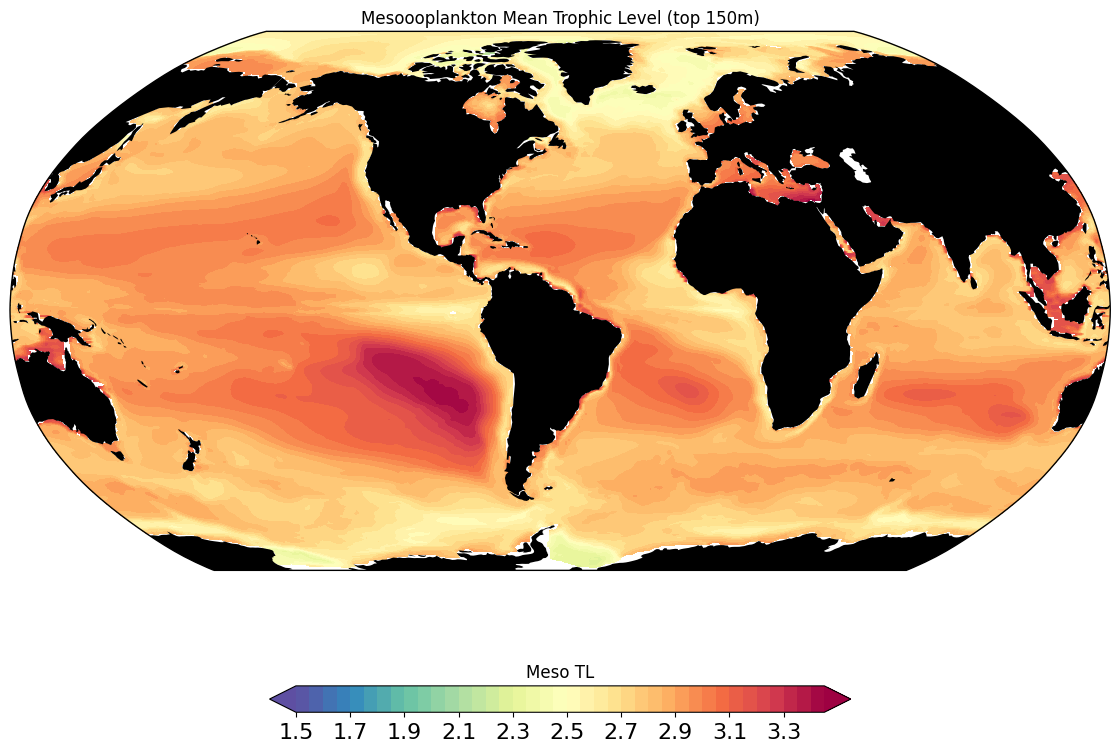

In [60]:
lev = np.arange(1.5, 3.5, 0.05)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)

fig = plt.figure(figsize=(15, 10))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, zoods.zooTL_g[2::,:,:,:,:].mean(dim=['z_t_150m','time','var']).values)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r', levels=lev, norm = norm,extend='both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('Meso TL')
ax.set_title('Mesoooplankton Mean Trophic Level (top 150m)');

In [54]:
zoods.zooTL_g[2::,:,:,:,:].shape

(4, 12, 15, 384, 320)

In [75]:
mask_less_than_zero = phytoC_zint.values < 0.1 # find all that are less than zero 
new_bmss = phytoC_zint.values
new_bmss[mask_less_than_zero] = np.nan # Make these values zero

In [ ]:
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, zoods.zooTL_g.mean(dim=['z_t_150m','time']).values)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r', levels=lev, norm = norm,extend='both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('Zoo TL')

In [ ]:
fig = plt.figure(figsize=(10, 10))

lat = pp_ds.lat

ax = fig.add_subplot(1, 1, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
zoo, lon = add_cyclic_point(np.nanmean(zooC_regrid,axis=0)/np.nanmean(new_bmss,axis=0), coord=pp_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,lat))
cf = m.pcolormesh(x,y,zoo,shading='flat',cmap='RdBu_r',vmin = 0.33, vmax=1.7)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, ticks=[0.333,0.666,1,1.333,1.666],shrink=0.75, orientation='horizontal')
cb.ax.set_xticklabels(['1:3','2:3','1:1','3:2','3:1'])
cb.ax.set_title('Zooplankton / Phytoplankton biomass ratio', fontsize = 30)
cb.ax.tick_params(labelsize=24)
#fig.text(0.01, 0.875, 'a',fontsize=35, fontweight='bold')
#fig.text(0.35, 0.875, 'b',fontsize=35, fontweight='bold')
#fig.text(0.7, 0.875, 'c',fontsize=35, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/AO/trophic_level'+new_file+'.png',dpi=600, bbox_inches='tight')